In [9]:
# general
import sys, os, path
import datetime

# nn related
import torch as th
import numpy as np
from numpy import linalg as la
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# postprocessing
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
import seaborn as sns
import tikzplotlib as tikz

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')

from scripts import preProcess as pre
from scripts import TensorBasedNN
from scripts.TensorBasedNN import TBNNGeneric
from scripts.utilities import *
from scripts.torchToFoam import writesymmtensor
from scripts.barymap import BarMap
from scripts import *

# standard datatype
dtype = th.double

In [10]:
# define u_bulk
u_bulk = 0.48196

with NoStdStreams():
    # read in rans solution from b_ml
    path = '/home/leonriccius/Desktop/SquareDuct/Re3500_kOmega_50_ml_low_lr_3/'
    rans_time = max([int(entry) for entry in os.listdir(path) if entry.isnumeric()])
    grid_rans = pre.readCellCenters(rans_time, path)
    u_rans = pre.readVectorData(rans_time, 'U', path)/u_bulk
    k_rans = pre.readScalarData(rans_time, 'k', path)/(u_bulk**2)
    u_levm = pre.readVectorData('50000', 'U', path)/u_bulk
    k_levm = pre.readScalarData('50000', 'k', path)/(u_bulk**2)

    # read in k epsilon model
    path_rans_bdns = '/home/leonriccius/Desktop/SquareDuct/Re3500_kEpsilon_50/'
    rans_time = max([int(entry) for entry in os.listdir(path_rans_bdns) if entry.isnumeric()])
    u_kepsilon = pre.readVectorData(rans_time, 'U', path_rans_bdns)/u_bulk
    k_kepsilon = pre.readScalarData(rans_time, 'k', path)/(u_bulk**2)

    # read in rans solution from b_dns
    path_rans_bdns = '/home/leonriccius/Desktop/SquareDuct/Re3500_kOmega_50_dns'
    rans_time = max([int(entry) for entry in os.listdir(path_rans_bdns) if entry.isnumeric()])
    u_rans_dns = pre.readVectorData(rans_time, 'U', path_rans_bdns)/u_bulk
    k_rans_dns = pre.readScalarData(rans_time, 'k', path)/(u_bulk**2)

    # read in dns solution
    path_dns = '/home/leonriccius/Documents/Fluid_Data/tensordata_fs1_fs2_fs3_reduced/SquareDuct/3500'
    grid_dns = th.load(os.sep.join([path_dns, 'grid-torch.th']))
    u_dns = th.load(os.sep.join([path_dns, 'u_dns-torch.th']))
    k_dns = th.load(os.sep.join([path_dns, 'k_dns-torch.th'])) ##*(u_bulk**2)

(80,)


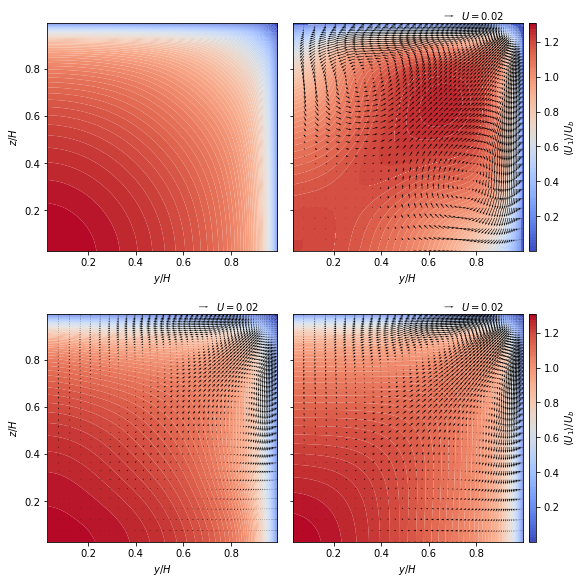

In [11]:
# set refinement level and extent of grid
ref = 50
gamma = 0.995

# find min an max of x coordinate
x_min, x_max = np.min(grid_rans[:,1].numpy()), np.max(grid_rans[:,2].numpy())
x_mean = 0.5*(x_max - x_min)
x_min = x_mean - gamma*(x_mean - x_min)
x_max = x_mean - gamma*(x_mean - x_max)

# find min an max of y coordinate
y_min, y_max = np.min(grid_rans[:,1].numpy()), np.max(grid_rans[:,2].numpy())
y_mean = 0.5*(y_max - y_min)
y_min = y_mean - gamma*(y_mean - y_min)
y_max = y_mean - gamma*(y_mean - y_max)

# compute number of points per coordinate
np_x = int(ref*(x_max - x_min))
np_y = int(ref*(y_max - y_min))

# get grid
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, np_x), np.linspace(y_min, y_max, np_y))

# interpolate u
grid_u_rans = griddata(grid_rans[:,1:3], u_rans.detach().numpy(), (grid_x, grid_y), method = 'cubic')
grid_u_levm = griddata(grid_rans[:,1:3], u_levm.detach().numpy(), (grid_x, grid_y), method = 'cubic')
grid_u_rans_dns = griddata(grid_dns[:,1:3], u_rans_dns.detach().numpy(), (grid_x, grid_y), method = 'cubic')
grid_u_dns = griddata(grid_dns[:,1:3], u_dns.detach().numpy(), (grid_x, grid_y), method = 'cubic')

# get min an max of (b_pred, b_test) for colormap
idx = [0]
tmp = th.norm(th.cat((u_levm, u_rans, u_dns, u_rans_dns)), dim=1).detach().numpy()
u_min = np.min(tmp)
u_max = np.max(tmp)
levels = np.linspace(u_min, u_max, 80)
print(levels.shape)

# plot layout
nrows = 2
ncols = 2
s = 1.0

# create figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*4.0*ncols, s*4.0*nrows), sharex=False, sharey=True,
                       constrained_layout=True)

# set colormap
cmap = matplotlib.cm.get_cmap("coolwarm")

# plot velocity magnitude
levm_plot = ax[0,0].contourf(grid_x, grid_y, np.linalg.norm(grid_u_levm, axis=2), levels=levels, cmap=cmap)
rans_plot = ax[0,1].contourf(grid_x, grid_y, np.linalg.norm(grid_u_rans, axis=2), levels=levels, cmap=cmap)
rans_dns_plot = ax[1,0].contourf(grid_x, grid_y, np.linalg.norm(grid_u_rans_dns, axis=2), levels=levels, cmap=cmap)
dns_plot = ax[1,1].contourf(grid_x, grid_y, np.linalg.norm(grid_u_dns, axis=2), levels=levels, cmap=cmap)

# plot in plane velocity vectors
array_scale=0.5
Q_rans = ax[0,1].quiver(grid_rans[:,1], grid_rans[:,2], u_rans[:,1], u_rans[:,2], scale=array_scale)
Q_rans_dns = ax[1,0].quiver(grid_rans[:,1], grid_rans[:,2], u_rans_dns[:,1], u_rans_dns[:,2], scale=array_scale)
Q_dns = ax[1,1].quiver(grid_rans[:,1], grid_rans[:,2], u_dns[:,1], u_dns[:,2], scale=array_scale)

# plot quiver keys
ax[1,0].quiverkey(Q_rans, 0.7, 1.03, 0.02, r'$U = 0.02$', labelpos='E',
                  coordinates='axes')
ax[0,1].quiverkey(Q_rans_dns, 0.7, 1.03, 0.02, r'$U = 0.02$', labelpos='E',
                  coordinates='axes')
ax[1,1].quiverkey(Q_dns, 0.7, 1.03, 0.02, r'$U = 0.02$', labelpos='E',
                  coordinates='axes')

# remove contour lines
for contour in [levm_plot, rans_plot, rans_dns_plot, dns_plot]:
    for c in contour.collections:
        c.set_edgecolor("face")
        c.set_linewidth(0.00000000000000001)

# set axis labels
for j in range(2):
    cbar = fig.colorbar(rans_plot, ax=ax[j,:].flat, aspect=15*ncols, format='%.1f', pad=0.0, ticks=np.arange(-0.2,1.4,0.2))
    cbar.set_label(r'$\langle U_1 \rangle / U_b$')

# set axis limits
for axis in ax.flat:
    axis.set_xlim([x_min,x_max])
    axis.set_ylim([y_min,y_max])
    
# set x labels
ax[1,0].set_xlabel(r'$y/H$', fontsize='medium')
ax[1,1].set_xlabel(r'$y/H$', fontsize='medium')
ax[0,0].set_xlabel(r'$y/H$', fontsize='medium')
ax[0,1].set_xlabel(r'$y/H$', fontsize='medium')

# set shared y labels
ax[0,0].set_ylabel(r'$z/H$', fontsize='medium')
ax[1,0].set_ylabel(r'$z/H$', fontsize='medium')

# empty title to create more space for  quiver key
for axs in ax.flat:
    axs.set_title(' ')

# save fig
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/numerical_results/propagation/square_duct'
fig_name =  'U_mag_contour_quiver.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

### RMSE for Velocities

In [7]:
print('komega     U_i: {:f},  U_23: {:f}   U_2:{:f},   U_3:{:f}'.format(th.sqrt(th.nn.MSELoss()(u_dns, u_levm)),
                                                                    th.sqrt(th.nn.MSELoss()(u_dns[:,1:3], u_levm[:,1:3])),
                                                                    th.sqrt(th.nn.MSELoss()(u_dns[:,1], u_levm[:,1])),
                                                                    th.sqrt(th.nn.MSELoss()(u_dns[:,2], u_levm[:,2]))))
print('kepsilon   U_i: {:f},  U_23: {:f}   U_2:{:f},   U_3:{:f}'.format(th.sqrt(th.nn.MSELoss()(u_dns, u_kepsilon)),
                                                                    th.sqrt(th.nn.MSELoss()(u_dns[:,1:3], u_kepsilon[:,1:3])),
                                                                    th.sqrt(th.nn.MSELoss()(u_dns[:,1], u_kepsilon[:,1])),
                                                                    th.sqrt(th.nn.MSELoss()(u_dns[:,2], u_kepsilon[:,2]))))
print('TBNN       U_i: {:f},  U_23: {:f}   U_2:{:f},   U_3:{:f}'.format(th.sqrt(th.nn.MSELoss()(u_dns, u_rans)),
                                                                    th.sqrt(th.nn.MSELoss()(u_dns[:,1:3], u_rans[:,1:3])),
                                                                    th.sqrt(th.nn.MSELoss()(u_dns[:,1], u_rans[:,1])),
                                                                    th.sqrt(th.nn.MSELoss()(u_dns[:,2], u_rans[:,2]))))
print('bDNS       U_i: {:f},  U_23: {:f}   U_2:{:f},   U_3:{:f}'.format(th.sqrt(th.nn.MSELoss()(u_dns, u_rans_dns)),
                                                                    th.sqrt(th.nn.MSELoss()(u_dns[:,1:3], u_rans_dns[:,1:3])),
                                                                    th.sqrt(th.nn.MSELoss()(u_dns[:,1], u_rans_dns[:,1])),
                                                                    th.sqrt(th.nn.MSELoss()(u_dns[:,2], u_rans_dns[:,2]))))

komega     U_i: 0.049592,  U_23: 0.006558   U_2:0.006569,   U_3:0.006547
kepsilon   U_i: 0.066687,  U_23: 0.006558   U_2:0.006569,   U_3:0.006547
TBNN       U_i: 0.071589,  U_23: 0.004519   U_2:0.004556,   U_3:0.004481
bDNS       U_i: 0.032202,  U_23: 0.002404   U_2:0.002464,   U_3:0.002342
